In [1]:
from pathlib import Path
import os
import getpass
import shutil
import subprocess

REPO_DIR = Path('/content/AnomalyDetection')
REPO_URL = os.environ.get('ANOMALY_REPO_URL', 'https://github.com/kh87joo2/AnomalyDetection.git')
FORCE_RECLONE = os.environ.get('ANOMALY_FORCE_RECLONE', '0') == '1'


def is_repo_root(path: Path) -> bool:
    required = [
        path / 'requirements.txt',
        path / 'configs',
        path / 'trainers',
        path / 'configs' / 'patchtst_ssl.yaml',
        path / 'configs' / 'swinmae_ssl.yaml',
    ]
    return all(p.exists() for p in required)


def clone_repo(repo_url: str, token: str = '') -> subprocess.CompletedProcess:
    clone_url = repo_url
    if token and repo_url.startswith('https://'):
        clone_url = repo_url.replace('https://', f'https://{token}@', 1)
    return subprocess.run(['git', 'clone', clone_url, str(REPO_DIR)], text=True, capture_output=True)


if is_repo_root(REPO_DIR):
    print(f'[info] using existing repo: {REPO_DIR}')
elif REPO_DIR.exists():
    if FORCE_RECLONE:
        print(f'[warn] removing existing directory because ANOMALY_FORCE_RECLONE=1: {REPO_DIR}')
        shutil.rmtree(REPO_DIR)
    else:
        raise RuntimeError(
            f'{REPO_DIR} exists but is not a valid repo root.\n'
            'Set ANOMALY_FORCE_RECLONE=1 to allow removal and reclone, or fix the directory manually.'
        )

if not is_repo_root(REPO_DIR):
    print(f'[info] cloning repo: {REPO_URL}')
    token = os.environ.get('ANOMALY_GH_TOKEN', '').strip()
    result = clone_repo(REPO_URL, token=token)

    if result.returncode != 0 and not token:
        print('[warn] public clone failed. If repo is private, enter a GitHub PAT.')
        token = getpass.getpass('GitHub PAT (private repo only): ').strip()
        if token:
            result = clone_repo(REPO_URL, token=token)

    if result.returncode != 0:
        if result.stderr:
            print('[git]', result.stderr.strip().splitlines()[-1])
        raise RuntimeError('git clone failed. Check repo URL, network, and token permissions.')

if not is_repo_root(REPO_DIR):
    raise FileNotFoundError('Repo root validation failed after clone.')

os.chdir(REPO_DIR)
print('cwd:', Path.cwd())
print('requirements.txt exists:', Path('requirements.txt').exists())
print('configs exists:', Path('configs').exists())
print('trainers exists:', Path('trainers').exists())


[info] cloning repo: https://github.com/kh87joo2/AnomalyDetection.git
cwd: /content/AnomalyDetection
requirements.txt exists: True
configs exists: True
trainers exists: True


In [4]:
import os, json, getpass
from pathlib import Path

user = input("Kaggle username: ").strip()
key = getpass.getpass("Kaggle API key: ").strip()  # 화면에 안 보임

os.environ["KAGGLE_USERNAME"] = user
os.environ["KAGGLE_KEY"] = key

p = Path("/root/.kaggle")
p.mkdir(parents=True, exist_ok=True)
with open(p / "kaggle.json", "w") as f:
    json.dump({"username": user, "key": key}, f)
os.chmod(p / "kaggle.json", 0o600)

print("kaggle auth ready")

kaggle auth ready


In [5]:
# KAGGLE_DATA_DOWNLOAD_PATCHTST
from pathlib import Path
import json
import os
import re
import shutil
import subprocess
import sys
import zipfile

import pandas as pd

REPO_DIR = Path('/content/AnomalyDetection')
RAW_DIR = REPO_DIR / 'data' / 'raw' / 'swat'
OUT_DIR = REPO_DIR / 'data' / 'fdc'
DATASET = 'vishala28/swat-dataset-secure-water-treatment-system'

RAW_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)


def run(cmd):
    cmd = [str(x) for x in cmd]
    print('$', ' '.join(cmd))
    subprocess.run(cmd, check=True)


run([sys.executable, '-m', 'pip', 'install', '-q', 'kaggle', 'pandas'])

kaggle_dir = Path('/root/.kaggle')
kaggle_dir.mkdir(parents=True, exist_ok=True)
kaggle_json = kaggle_dir / 'kaggle.json'

if not kaggle_json.exists():
    user = os.environ.get('KAGGLE_USERNAME', '').strip()
    key = os.environ.get('KAGGLE_KEY', '').strip()
    if user and key:
        kaggle_json.write_text(json.dumps({'username': user, 'key': key}), encoding='utf-8')
    else:
        from google.colab import files

        print('Upload kaggle.json from https://www.kaggle.com/settings/account')
        uploaded = files.upload()
        if 'kaggle.json' not in uploaded:
            raise FileNotFoundError('kaggle.json not uploaded')
        with kaggle_json.open('wb') as f:
            f.write(uploaded['kaggle.json'])

os.chmod(kaggle_json, 0o600)

run(['kaggle', 'datasets', 'download', '-d', DATASET, '-p', str(RAW_DIR), '--force'])

for zip_path in sorted(RAW_DIR.glob('*.zip')):
    print('[extract]', zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(RAW_DIR)

csv_files = sorted(RAW_DIR.rglob('*.csv'))
if not csv_files:
    raise FileNotFoundError(f'No CSV found under {RAW_DIR}')

print('csv_found:', len(csv_files))
for p in csv_files[:20]:
    print('-', p)


def pick_fdc_csv(files):
    def score(path: Path):
        name = path.name.lower()
        if 'normal' in name:
            return (0, len(name))
        if 'train' in name:
            return (1, len(name))
        if 'attack' in name:
            return (9, len(name))
        return (5, len(name))

    return sorted(files, key=score)[0]


src = pick_fdc_csv(csv_files)
print('selected_source:', src)

df = pd.read_csv(src)
orig_cols = list(df.columns)

col_map = {str(c).strip().lower(): c for c in df.columns}
ts_col = None
for key in ['timestamp', 'time', 'datetime', 'date']:
    if key in col_map:
        ts_col = col_map[key]
        break

if ts_col is None:
    df.insert(0, 'timestamp', range(len(df)))
else:
    df = df.rename(columns={ts_col: 'timestamp'})

# Drop common label columns if present.
drop_names = {'label', 'attack', 'normal/attack', 'normal_attack', 'class', 'status'}
for c in list(df.columns):
    if str(c).strip().lower() in drop_names:
        df = df.drop(columns=[c])

# Numeric-cast all non-timestamp columns.
feature_cols = [c for c in df.columns if c != 'timestamp']
for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

out_csv = OUT_DIR / 'swat_fdc_train.csv'
df.to_csv(out_csv, index=False)

print('prepared_csv:', out_csv)
print('shape:', df.shape)
print('columns_in:', len(orig_cols), 'columns_out:', len(df.columns))
print('next_config: data.source=csv, data.path=/content/AnomalyDetection/data/fdc/*.csv')


$ /usr/bin/python3 -m pip install -q kaggle pandas
$ kaggle datasets download -d vishala28/swat-dataset-secure-water-treatment-system -p /content/AnomalyDetection/data/raw/swat --force
[extract] /content/AnomalyDetection/data/raw/swat/swat-dataset-secure-water-treatment-system.zip
csv_found: 3
- /content/AnomalyDetection/data/raw/swat/attack.csv
- /content/AnomalyDetection/data/raw/swat/merged.csv
- /content/AnomalyDetection/data/raw/swat/normal.csv
selected_source: /content/AnomalyDetection/data/raw/swat/normal.csv
prepared_csv: /content/AnomalyDetection/data/fdc/swat_fdc_train.csv
shape: (1387098, 52)
columns_in: 53 columns_out: 52
next_config: data.source=csv, data.path=/content/AnomalyDetection/data/fdc/*.csv


In [6]:
import pandas as pd
from pathlib import Path

p = Path("/content/AnomalyDetection/data/fdc/swat_fdc_train.csv")
df = pd.read_csv(p)

print("path:", p)
print("shape:", df.shape)
print("columns:", df.columns.tolist())
print(df.head(10))

path: /content/AnomalyDetection/data/fdc/swat_fdc_train.csv
shape: (1387098, 52)
columns: ['timestamp', 'FIT101', 'LIT101', ' MV101', 'P101', 'P102', ' AIT201', 'AIT202', 'AIT203', 'FIT201', ' MV201', ' P201', ' P202', 'P203', ' P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', ' MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603']
                 timestamp    FIT101    LIT101   MV101  P101  P102    AIT201  \
0   28/12/2015 10:00:00 AM  2.427057  522.8467     2.0     2     1  262.0161   
1   28/12/2015 10:00:01 AM  2.446274  522.8860     2.0     2     1  262.0161   
2   28/12/2015 10:00:02 AM  2.489191  522.8467     2.0     2     1  262.0161   
3   28/12/2015 10:00:03 AM  2.534350  522.9645     2.0     2     1  262.0161   
4   28/12/2015 10:00:04

/tmp/ipython-input-1476800112.py:15: UserWarning: Parsing dates in  %d/%m/%Y %I:%M:%S %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  x = pd.to_datetime(plot_df["timestamp"], errors="coerce")


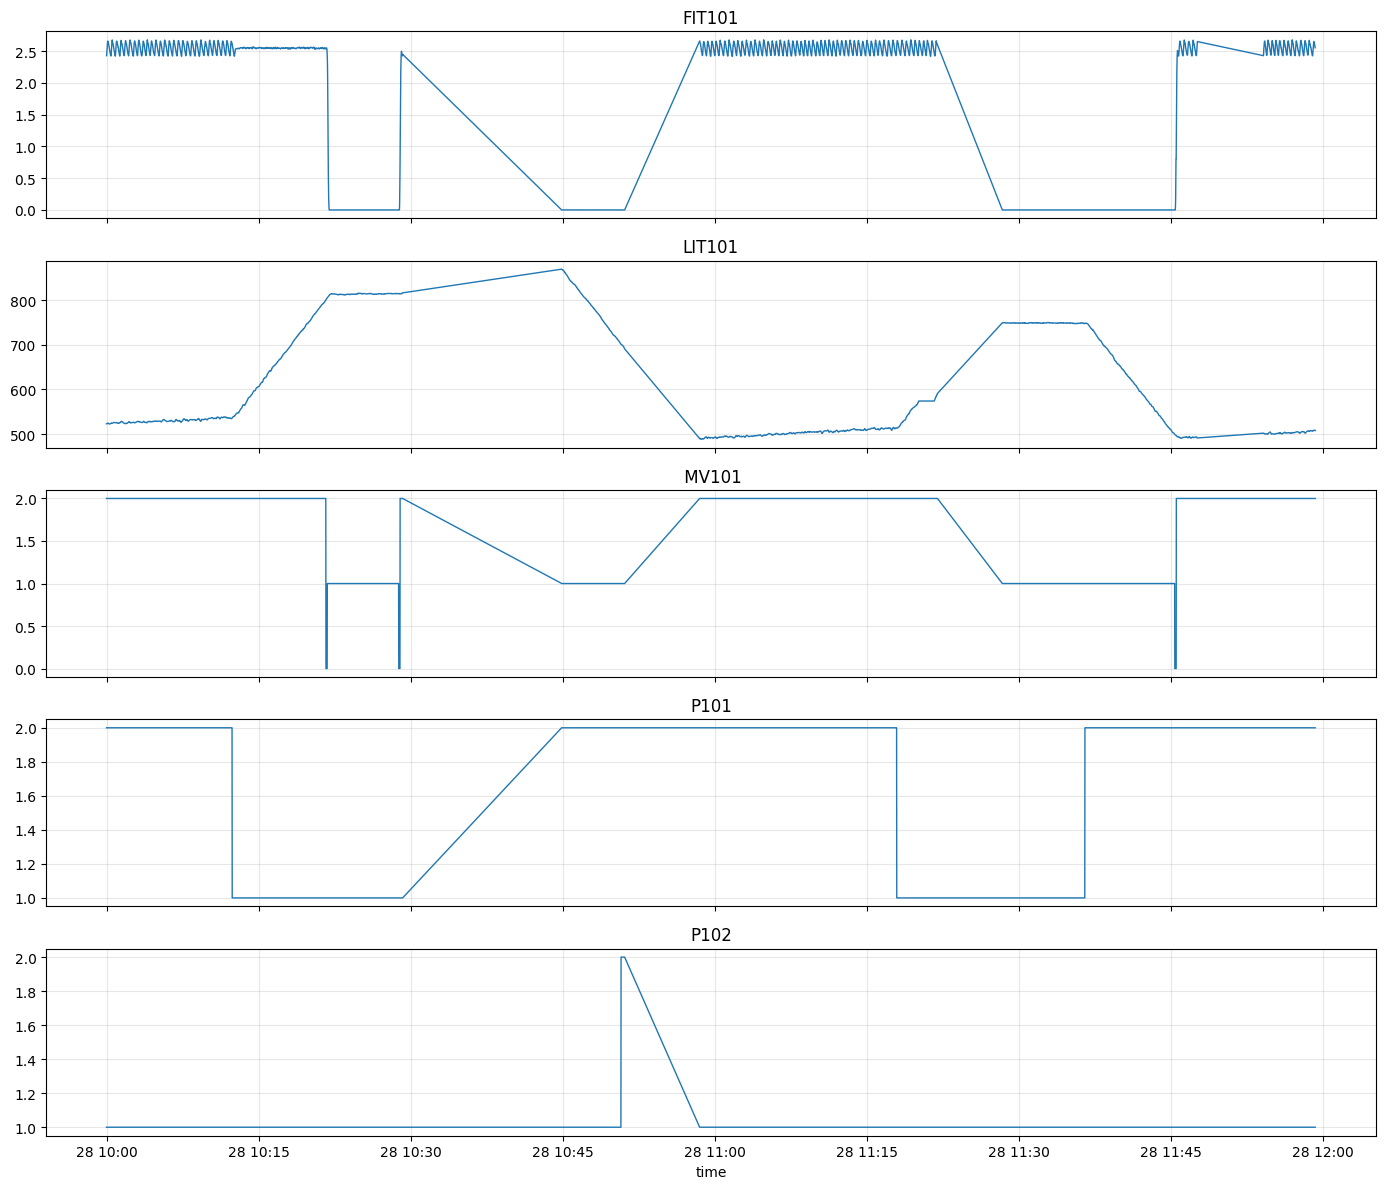

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

p = Path("/content/AnomalyDetection/data/fdc/swat_fdc_train.csv")
df = pd.read_csv(p)

# timestamp 제외 센서 5개 선택
sensor_cols = [c for c in df.columns if c != "timestamp"][:5]

# 가볍게 앞 5000개만
plot_df = df.iloc[:5000].copy()

# x축
x = pd.to_datetime(plot_df["timestamp"], errors="coerce")
if x.isna().all():
    x = plot_df.index

fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

for i, c in enumerate(sensor_cols):
    axes[i].plot(x, plot_df[c], linewidth=1)
    axes[i].set_title(c)
    axes[i].grid(alpha=0.3)

axes[-1].set_xlabel("time")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1314550243.py:38: UserWarning: Parsing dates in  %d/%m/%Y %I:%M:%S %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  normal_x = pd.to_datetime(normal_plot["timestamp"], errors="coerce")
/tmp/ipython-input-1314550243.py:42: UserWarning: Parsing dates in  %d/%m/%Y %I:%M:%S %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  attack_x = pd.to_datetime(attack_plot["timestamp"], errors="coerce")


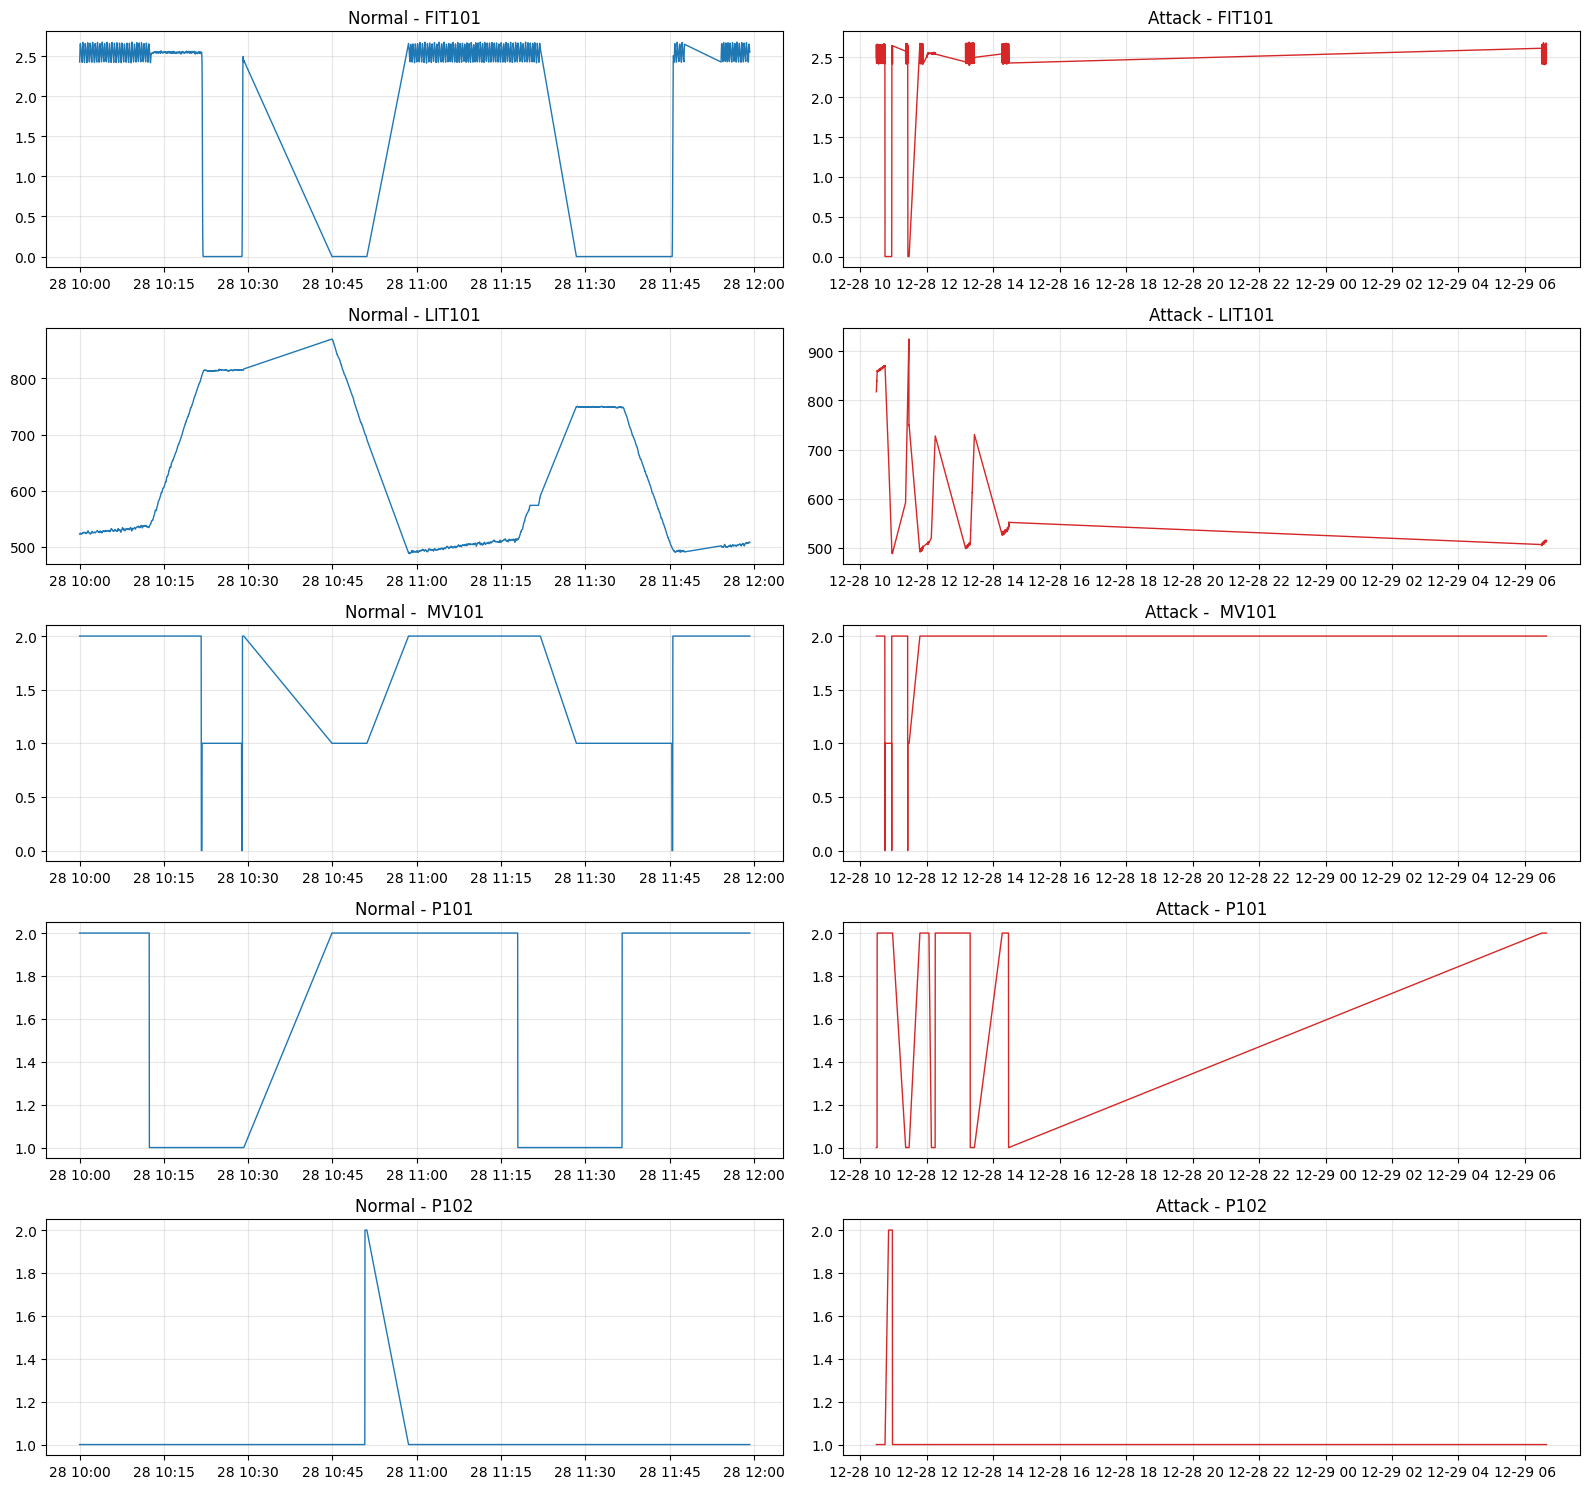

Compared sensors: ['FIT101', 'LIT101', ' MV101', 'P101', 'P102']


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 원본 normal/attack 파일 경로
normal_path = Path("/content/AnomalyDetection/data/raw/swat/normal.csv")
attack_path = Path("/content/AnomalyDetection/data/raw/swat/attack.csv")

# 데이터 로드
normal_df = pd.read_csv(normal_path)
attack_df = pd.read_csv(attack_path)

# timestamp 컬럼 이름 통일 함수
def normalize_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    col_map = {str(c).strip().lower(): c for c in df.columns}
    for key in ["timestamp", "time", "datetime", "date"]:
        if key in col_map:
            return df.rename(columns={col_map[key]: "timestamp"})
    # timestamp가 없으면 인덱스를 시간축 대체로 사용
    df.insert(0, "timestamp", range(len(df)))
    return df

normal_df = normalize_timestamp(normal_df)
attack_df = normalize_timestamp(attack_df)

# 공통 센서 컬럼만 추출 (timestamp 제외)
normal_sensors = [c for c in normal_df.columns if c != "timestamp"]
attack_sensors = [c for c in attack_df.columns if c != "timestamp"]
common_sensors = [c for c in normal_sensors if c in attack_sensors][:5]

# 시각화 부담을 줄이기 위해 앞 5000개만 사용
n_plot = 5000
normal_plot = normal_df.iloc[:n_plot].copy()
attack_plot = attack_df.iloc[:n_plot].copy()

# timestamp를 datetime으로 변환 시도, 실패 시 index 사용
normal_x = pd.to_datetime(normal_plot["timestamp"], errors="coerce")
if normal_x.isna().all():
    normal_x = normal_plot.index

attack_x = pd.to_datetime(attack_plot["timestamp"], errors="coerce")
if attack_x.isna().all():
    attack_x = attack_plot.index

# 5개 센서를 각각 행으로, normal/attack을 좌우 컬럼으로 비교
fig, axes = plt.subplots(
    nrows=len(common_sensors),
    ncols=2,
    figsize=(16, 3 * len(common_sensors)),
    sharex=False
)

# 센서가 1개일 때 axes 차원 보정
if len(common_sensors) == 1:
    axes = [axes]

for i, sensor in enumerate(common_sensors):
    # 좌측: normal
    axes[i][0].plot(normal_x, pd.to_numeric(normal_plot[sensor], errors="coerce"), linewidth=1)
    axes[i][0].set_title(f"Normal - {sensor}")
    axes[i][0].grid(alpha=0.3)

    # 우측: attack
    axes[i][1].plot(attack_x, pd.to_numeric(attack_plot[sensor], errors="coerce"), linewidth=1, color="tab:red")
    axes[i][1].set_title(f"Attack - {sensor}")
    axes[i][1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Compared sensors:", common_sensors)

In [10]:
from pathlib import Path
import subprocess
import sys
import shlex


def run(cmd):
    cmd = [str(x) for x in cmd]
    print('$', ' '.join(shlex.quote(x) for x in cmd))
    proc = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1,
    )

    assert proc.stdout is not None
    for line in proc.stdout:
        print(line, end='')

    code = proc.wait()
    if code != 0:
        raise RuntimeError(f"Command failed ({code}): {' '.join(cmd)}")


req = Path('requirements.txt')
if not req.exists():
    raise FileNotFoundError(
        f"requirements.txt not found in cwd={Path.cwd()}. Run bootstrap cell first or fix repo path."
    )

run([sys.executable, '-m', 'pip', 'install', '-U', 'pip'])
run([sys.executable, '-m', 'pip', 'install', '-r', str(req)])


$ /usr/bin/python3 -m pip install -U pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
$ /usr/bin/python3 -m pip install -r requirements.txt


In [11]:
import torch

print('torch:', torch.__version__)
print('cuda_available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('cuda_device_count:', torch.cuda.device_count())
    print('cuda_device_0:', torch.cuda.get_device_name(0))


torch: 2.10.0+cu128
cuda_available: True
cuda_device_count: 1
cuda_device_0: Tesla T4


In [14]:
import os
import shlex
import subprocess
import sys
from pathlib import Path

def run_stream(cmd):
    cmd = [str(x) for x in cmd]
    print('$', ' '.join(shlex.quote(x) for x in cmd))

    env = os.environ.copy()
    env["PYTHONUNBUFFERED"] = "1"

    proc = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1,
        env=env,
    )

    assert proc.stdout is not None
    for line in proc.stdout:
        print(line, end='')

    code = proc.wait()
    if code != 0:
        raise RuntimeError(f"Training failed with exit code {code}")

# 실데이터 config 우선, 없으면 synthetic fallback
cfg = Path("configs/patchtst_ssl_real.yaml")
if not cfg.exists():
    print("[warn] real config not found, fallback to synthetic config")
    cfg = Path("configs/patchtst_ssl.yaml")

run_stream([sys.executable, "-u", "-m", "trainers.train_patchtst_ssl", "--config", str(cfg)])

[warn] real config not found, fallback to synthetic config
$ /usr/bin/python3 -u -m trainers.train_patchtst_ssl --config configs/patchtst_ssl.yaml
2026-02-21 01:07:11.324073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771636031.345431   19592 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771636031.352555   19592 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771636031.370553   19592 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771636031.370584   19592 computation_placer.cc:177] computation placer already registered. Please chec

In [15]:
from pathlib import Path

checkpoint_path = Path('checkpoints/patchtst_ssl.pt')
print('checkpoint_exists:', checkpoint_path.exists(), checkpoint_path)
assert checkpoint_path.exists(), f'Missing checkpoint: {checkpoint_path}'
print('checkpoint_size_bytes:', checkpoint_path.stat().st_size)


checkpoint_exists: True checkpoints/patchtst_ssl.pt
checkpoint_size_bytes: 4921353
